# **1. U-Net 구현**
## 1. 문제 정의 및 목표 설정
* 목표:
  * 이미지 손실 복원: 손상되어 결손된 영역을 자연스럽게 복구
  * 이미지 색상화: 흑백 이미지에 자연스러운 색을 입혀 원본과 유사하게 재현

## 2. 데이터 분석 및 전처리
* 데이터 확인:
    * 제공된 데이터셋은 train_input(손상된 흑백 이미지)와 train_gt(완전한 컬러 이미지)로 구성되며, 매칭 정보는 train.csv에 기록되어 있음
    * 결손 영역(손실된 부분)이 있는지, 혹은 별도의 마스크 정보가 포함되어 있는지 확인
* 전처리:
    * 정규화: 모든 이미지의 픽셀 값을 [0,1] 범위로 스케일링
    * 마스크 처리: (필요하다면) 손실된 영역을 별도 채널로 분리하여 모델 입력에 추가
    * 데이터 증강: 회전, 크기 조절, 좌우 반전 등 다양한 증강 기법을 적용해 모델의 일반화 성능 향상

## 3. 모델 아키텍처 설계
* 기본 아이디어:
    * 엔코더-디코더 구조: U-Net과 같이 입력 이미지에서 중요한 특징을 추출(인코더)한 후, 업샘플링을 통해 원래 크기로 복원(디코더)
    * 스킵 연결: 인코더에서 추출한 고해상도 세부 정보를 디코더와 직접 연결하여 정보 손실을 최소화
* 다중 작업 접근법:
  * 하나의 모델 내에서 두 branch로 분기하여 손실 복원(inpainting)과 색상화(colorization)를 동시에 수행할 수 있음.

## 4. 손실 함수 및 최적화
* 재구성 손실 (L1/L2 Loss):
    * 복원 및 색상화 결과와 정답 이미지 간의 차이를 최소화

## 5. 학습 및 평가 전략
* 학습 전략:
    * Adam과 같은 옵티마이저를 사용하고, 학습률 스케줄링을 적용
* 평가 지표:
    * SSIM 등 정량적 지표와 함께, 시각적 평가로 복원 결과의 자연스러움을 확인

## 6. 실험 및 모델 개선
* 실험 계획:
    * Baseline 모델: 간단한 U-Net부터 시작하여 기본 성능을 확인

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Dataset 클래스: GT 컬러 이미지와 손실된 그레이스케일 이미지의 차이를 통해 손실 영역 마스크 생성
class RestorationDataset(Dataset):
    def __init__(self, csv_path, input_dir, gt_dir, transform=None, mask_threshold=0.1):
        """
        csv_path: 매칭 정보를 담은 CSV 파일 경로 (컬럼: input_image_path, gt_image_path)
        input_dir: 손상된 흑백 이미지 폴더 (train_input)
        gt_dir: 완전한 컬러 이미지 폴더 (train_gt)
        mask_threshold: 손실 영역 판단을 위한 임계값 (0~1 사이, 차이가 이 값보다 크면 손실 영역으로 판단)
        """
        self.csv_data = pd.read_csv(csv_path)
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.mask_threshold = mask_threshold

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        row = self.csv_data.iloc[idx]
        input_filename = row['input_image_path']
        gt_filename = row['gt_image_path']

        # 손상된 그레이스케일 이미지 불러오기
        input_path = os.path.join(self.input_dir, input_filename)
        gray_img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if gray_img is None:
            raise ValueError(f"입력 이미지 로드 실패: {input_path}")
        gray_img = gray_img.astype(np.float32) / 255.0   # [0,1] 정규화
        gray_img = np.expand_dims(gray_img, axis=0)        # (H,W) -> (1,H,W)

        # 완전한 컬러 이미지 불러오기
        gt_path = os.path.join(self.gt_dir, gt_filename)
        color_img = cv2.imread(gt_path, cv2.IMREAD_COLOR)
        if color_img is None:
            raise ValueError(f"GT 이미지 로드 실패: {gt_path}")
        color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
        color_img = color_img.astype(np.float32) / 255.0    # [0,1] 정규화
        color_img = np.transpose(color_img, (2, 0, 1))       # (H,W,3) -> (3,H,W)

        # GT 컬러 이미지를 그레이스케일로 변환 (수동 계산: R,G,B 가중치)
        gt_gray = 0.2989 * color_img[0] + 0.5870 * color_img[1] + 0.1140 * color_img[2]
        gt_gray = np.expand_dims(gt_gray, axis=0)            # (1,H,W)

        # 손실 영역 마스크 생성: 두 이미지의 그레이스케일 차이가 임계값보다 크면 1, 아니면 0
        lost_mask = (np.abs(gray_img - gt_gray) > self.mask_threshold).astype(np.float32)  # (1,H,W)

        # 입력 데이터: 채널 1 - 손상된 그레이스케일, 채널 2 - 손실 영역 마스크
        combined_input = np.concatenate([gray_img, lost_mask], axis=0)  # (2,H,W)

        sample = {
            'input': torch.tensor(combined_input, dtype=torch.float32),  # (2,H,W)
            'gt': torch.tensor(color_img, dtype=torch.float32)           # (3,H,W)
        }
        if self.transform:
            sample = self.transform(sample)
        return sample

# 파일 경로 설정 (예시: Google Drive)
csv_path = '/content/drive/MyDrive/DACON/train.csv'
input_dir = '/content/drive/MyDrive/DACON/'
gt_dir = '/content/drive/MyDrive/DACON/'

# 데이터셋 생성 및 학습/테스트 분할 (총 2000개 데이터 기준)
dataset = RestorationDataset(csv_path, input_dir, gt_dir, mask_threshold=0.1)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 생성 (배치 크기 8)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [3]:
# U-Net 구성 요소
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=3):
        """
        in_channels: 2 (손상된 그레이스케일 + 손실 영역 마스크)
        out_channels: 3 (복원된 컬러 이미지)
        """
        super(UNet, self).__init__()
        # 인코더
        self.enc1 = UNetBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = UNetBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = UNetBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = UNetBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # 병목
        self.bottleneck = UNetBlock(512, 1024)

        # 디코더
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = UNetBlock(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = UNetBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = UNetBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = UNetBlock(128, 64)

        # 최종 출력: 1x1 컨볼루션
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # 인코더 단계
        enc1 = self.enc1(x)                # (B,64,H,H)
        enc2 = self.enc2(self.pool1(enc1))   # (B,128,H/2,H/2)
        enc3 = self.enc3(self.pool2(enc2))   # (B,256,H/4,H/4)
        enc4 = self.enc4(self.pool3(enc3))   # (B,512,H/8,H/8)

        bottleneck = self.bottleneck(self.pool4(enc4))  # (B,1024,H/16,H/16)

        # 디코더 단계 (스킵 연결)
        up4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))

        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))

        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        return self.final_conv(dec1)


In [4]:
# 디바이스 설정 및 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=2, out_channels=3).to(device)

# 손실 함수: 전체 이미지에 대한 L1 손실과, 손실 영역에 집중한 인페인팅 손실을 결합
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
lambda_inpainting = 2.0  # 인페인팅 손실 가중치

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs = batch['input'].to(device)   # (B,2,H,W): [그레이스케일, 손실 마스크]
        targets = batch['gt'].to(device)       # (B,3,H,W)

        optimizer.zero_grad()
        outputs = model(inputs)                # (B,3,H,W)

        # 전체 색상화 손실
        color_loss = criterion(outputs, targets)

        # 손실 영역 인페인팅 손실: 마스크 영역만 L1 손실을 계산
        mask = inputs[:, 1:2, :, :]            # (B,1,H,W)
        mask_expanded = mask.expand_as(outputs)
        inpainting_loss = torch.sum(torch.abs(outputs - targets) * mask_expanded) / (torch.sum(mask_expanded) + 1e-6)

        total_loss = color_loss + lambda_inpainting * inpainting_loss
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.5326
Epoch 2/10, Loss: 0.4595
Epoch 3/10, Loss: 0.4476
Epoch 4/10, Loss: 0.4342
Epoch 5/10, Loss: 0.4213
Epoch 6/10, Loss: 0.4206
Epoch 7/10, Loss: 0.4214
Epoch 8/10, Loss: 0.3969
Epoch 9/10, Loss: 0.3805
Epoch 10/10, Loss: 0.3721


In [5]:
# !fc-list :lang=ko
!apt-get update -qq
!apt-get install -qq fonts-nanum
!fc-cache -f -v

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

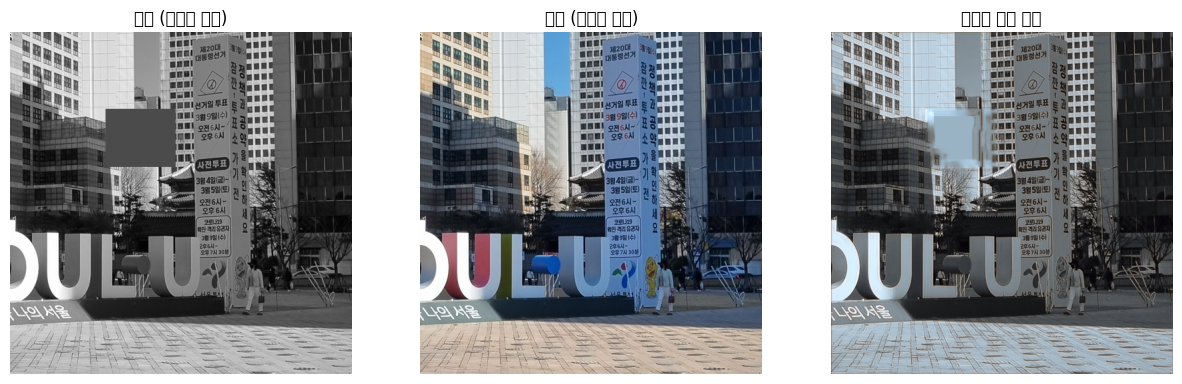

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 평가 모드로 전환
model.eval()
with torch.no_grad():
    # 테스트용 DataLoader(test_loader)로부터 한 배치 가져오기
    for batch in test_loader:
        inputs = batch['input'].to(device)   # (B, 1, H, W)
        targets = batch['gt'].to(device)       # (B, 3, H, W)
        outputs = model(inputs)                # 모델 추론 결과: (B, 3, H, W)

        # 텐서를 CPU로 이동 후 numpy 배열로 변환
        inputs_np = inputs.cpu().numpy()
        targets_np = targets.cpu().numpy()
        outputs_np = outputs.cpu().numpy()

        # 배치의 첫 번째 샘플에 대해 시각화
        plt.figure(figsize=(15, 5))

        # 입력 이미지 (흑백)
        plt.subplot(1, 3, 1)
        plt.imshow(inputs_np[0, 0, :, :], cmap='gray')
        plt.title("입력 (손상된 흑백)")
        plt.axis("off")

        # 정답 이미지 (컬러): (3, H, W) → (H, W, 3)
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(targets_np[0], (1, 2, 0)))
        plt.title("정답 (완전한 컬러)")
        plt.axis("off")

        # 모델 출력 이미지 (복원된 컬러)
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(outputs_np[0], (1, 2, 0)))
        plt.title("복원된 컬러 출력")
        plt.axis("off")

        plt.show()
        break  # 한 배치만 시각화
